In [73]:
from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
import numpy as np
import sys
sys.path.append("/home/jovyan/P1-Temp-Reg/modelbased-approach/")
import auxiliary_functions as aux
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator

In [74]:
filepath_y = "/home/jovyan/P1-Temp-Reg/y_4.h5"
y = AcquisitionData(filepath_y)
csm = CoilSensitivityData()
csm.calculate(y)
u = ImageData()
u.from_acquisition_data(y)
A= AcquisitionModel(acqs=y, imgs=u)
A.set_coil_sensitivity_maps(csm)

Started reading acquisitions from /home/jovyan/P1-Temp-Reg/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/P1-Temp-Reg/y_4.h5


In [75]:
beta_1 = 0.1
beta_2 = 0.1

In [76]:
a = np.random.rand(12,128,128)

In [77]:
np.shape(a)

(12, 128, 128)

In [78]:
class LHS():
    def __init__(self, template,beta_x, beta_t,A,Dx,Dt):
        self.template=template
        self.beta_x = beta_x
        self.beta_t = beta_t
        self.A = A
        self.Dx = Dx
        self.Dt = Dt
    
    def forward(self,u):
        b = self.template.copy().fill(np.reshape(u,self.template.shape))
        return self.Left_hand_side(b)
        
    def Left_hand_side(self, u):

        first_part = self.A.backward(self.A.forward(u))
        second_part = self.beta_t*self.Dt.backward(self.Dt.backward(u))
        third_part = self.beta_x * self.Dx.backward(self.Dx.forward(u))
        return (first_part + second_part + third_part).as_array().flatten()
    
    def prox(self, alpha,x):
        prox_output = x.as_array()
        prox_output = np.sign(x)*np.max(np.abs(x) -  alpha,0)
        return self.template.copy().fill(prox_output)



In [85]:
def asdf(u, beta_x, beta_t,A,Dx,Dt):
    u=ImageData(u)
    
    first_part = A.backward(A.forward(u))
    second_part = beta_t*Dt.backward(Dt.backward(u))
    third_part = beta_x * Dx.backward(Dx.forward(u))
    return first_part + second_part + third_part
    
def Right_hand_side(y,mu_x, mu_t, z_x, z_t, beta_x,beta_t, A,Dx,Dt):
    return (A.backward(y) - Dx.backward(mu_x)- Dt.backward(mu_t)
            + beta_t*Dt.backward(z_t) + beta_x*Dx.backward(z_x))


def solve_u_step(lhs,u_k,zt_k,zx_k,beta_x,beta_t,mut_k,mux_k, y,A,Dx,Dt):
    operator_shape= (u_k.as_array().size, u_k.as_array().size)
    RHS = Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt)
    Operator = LinearOperator( operator_shape, matvec=lhs.forward )
    #LHS = lambda u : Left_hand_side(u, beta_x, beta_t,A,Dx,Dt)
    
    
    u_next = bicgstab(Operator, RHS.as_array().flatten(), u_k.as_array().flatten())
    return lhs.template.copy().fill(u_next)
    
    
#LHS = lambda u : Left_hand_side(u, beta_x, beta_t,A)
def alternating_lagrange_multiplier(max_iter):
    u_k = compute_init_u(y,A)
    Dx = aux.Dx()
    Dt = aux.Dt()
    zt_k = Dt.forward(u_k)
    zx_k = Dx.forward(u_k)

    zt_k.fill(0)
    zx_k[0].fill(0)
    zx_k[1].fill(0)

    print(zx_k)
    mut_k = zt_k.copy()
    mut_k.fill(0.0)
    
    c=1
    alpha_t = c*mut_k.copy().fill(1)
    alpha_x = (c*mut_k.copy().fill(1), c*mut_k.copy().fill(1))
    lhs = LHS(u_k,beta_x, beta_t,A,Dx,Dt)
    mux_k = (zx_k[0].copy().fill(0), zx_k[1].copy().fill(1))
    for i in range(max_iter):
        
        time_start = time.time()
        #run your code

        u_k = solve_u_step(lhs, u_k,zt_k,zx_k,beta_1,beta_2,mut_k,mux_k, y,A,Dx,Dt)
        time_elapsed = (time.time()- time_start)
        zk_t = lhs.prox(alpha_t/beta_t,mut_k/beta_t+Dt.forward(u_k))
        zk_x = lhs.prox(alpha_x/beta_x,mux_k/beta_x+Dx.forward(u_k))
        mut_k += beta_t*(zt_k +Dx.forward(u_k))
        mux_k += beta_x*(zx_k +Dx.forward(u_k))
        
        time_end = time.time()
        print(i,time_end-time_start)
    return u_k, zk_t, zk_x, mut_k, mux_k


In [80]:
def compute_init_u(y,A):
    return A.backward(y)

In [82]:
u_k = compute_init_u(y,A)
print(type(u_k))

<class 'sirf.Gadgetron.ImageData'>


In [83]:
#B = LinearOperator((2,2), matvec=LHS)


(<sirf.Gadgetron.ImageData object at 0x7fc1e1a04550>, <sirf.Gadgetron.ImageData object at 0x7fc1da5fd7c0>)


In [84]:
import time

time_start = time.time()
#run your code

result = solve_u_step(u_k,zt_k,zx_k,beta_1,beta_2,mut_k,mux_k, y,A,Dx,Dt)
time_elapsed = (time.time()- time_start)
print(time_elapsed)

49.88070201873779


(196608,)


Text(0.5, 1.0, 'end')

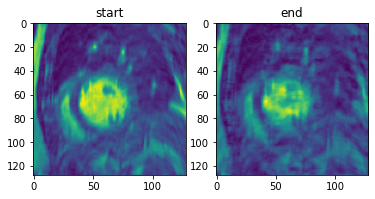

In [70]:
print((result[0].shape))

resimg = np.reshape(result[0], (12,128,128))
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,2)
ax[0].imshow(np.abs(np.squeeze(u_k.as_array()[3,:,:])))
ax[0].set_title('start')
ax[1].imshow(np.abs(np.squeeze(resimg[3,:,:])))
ax[1].set_title('end')


In [87]:
alternating_lagrange_multiplier(1)

(<sirf.Gadgetron.ImageData object at 0x7fc1eb685a60>, <sirf.Gadgetron.ImageData object at 0x7fc1eb685790>)


NameError: name 'c' is not defined